# Sentimental Analysis

## I. Load and read data

In [9]:
# import libraries
# load dataset
import pandas as pd

# clean the dataset
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

# analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# train and test
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# train model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('data/IMDB-Dataset.csv')

# remove duplicate rows
df = df.drop_duplicates()

## II. Clean data

In [4]:
stop = set(stopwords.words('english'))

# expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, 'html.parser') # remove html tags
    text = soup.get_text()
    text = expand_contractions(text) # expand chatwords and contracts clearing contractions
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F" # emoticons
                             u"\U0001F300-\U0001F5FF" # symbols & pictographs
                             u"\U0001F680-\U0001F6FF" # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text) # add space after period
    text = re.sub(r'http\S+', '', text) # remove urls
    text = " ".join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) # lemmatize and remove stopwords
    return text

df['review'] = df['review'].apply(preprocess_text)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15764\1935064246.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser') # remove html tags


## III. Autopct and analyze data

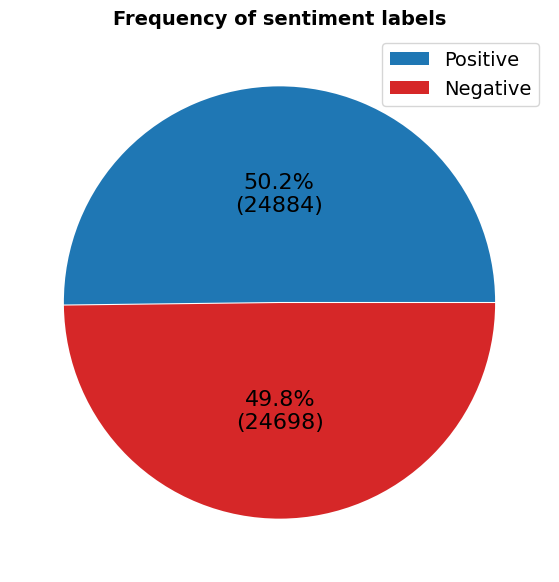

In [5]:
# create autopct arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']

# create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data,
        autopct=lambda pct: func(pct, data),
        explode = [0.0025] * 2,
        pctdistance = 0.5,
        colors = [sns.color_palette()[0], 'tab:red'],
        textprops = {'fontsize': 16})
plt.title("Frequency of sentiment labels", fontsize=14, fontweight='bold')
labels = [r'Positive', r'Negative']
plt.legend(labels, loc='best', prop={'size': 14})
pie.savefig('PieChart.png')
plt.show()

## IV. Words length of each labels

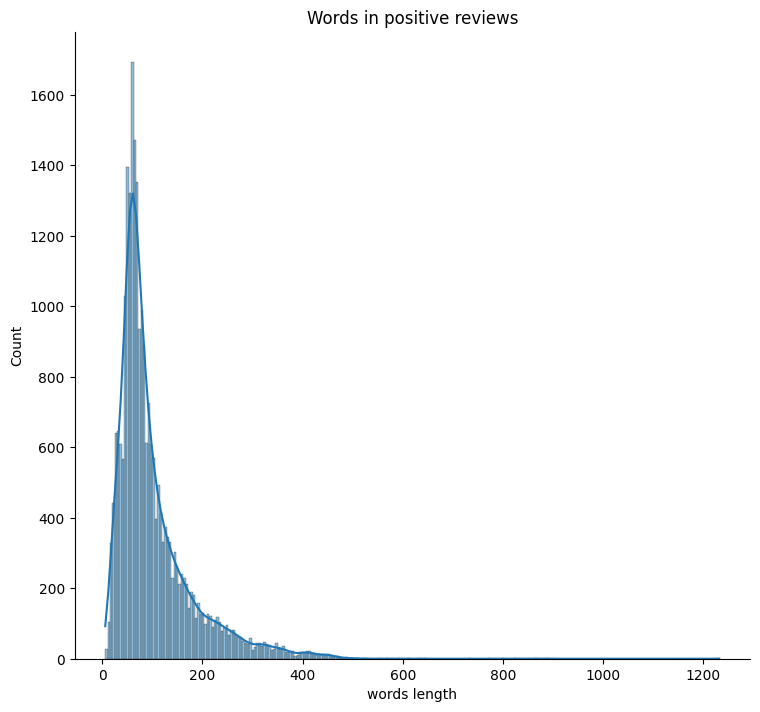

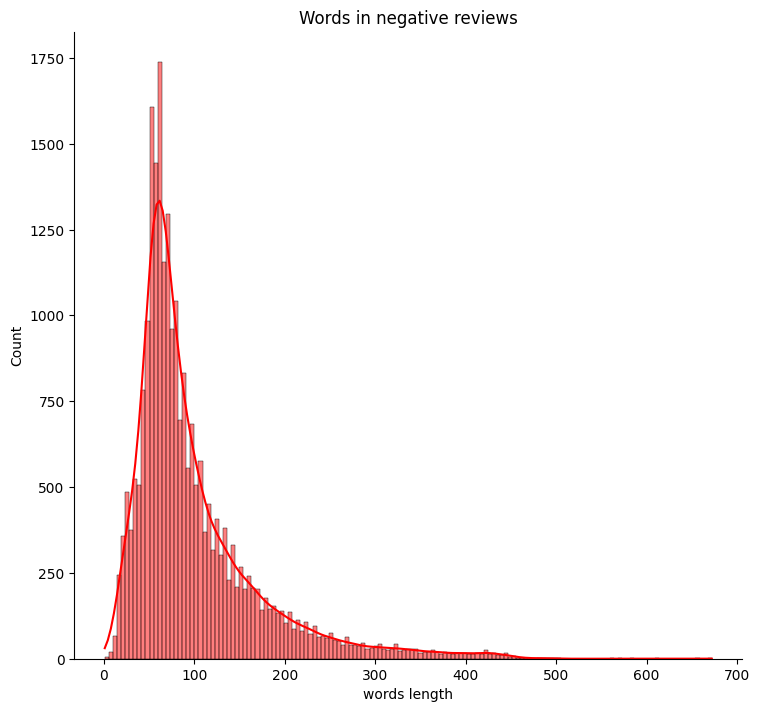

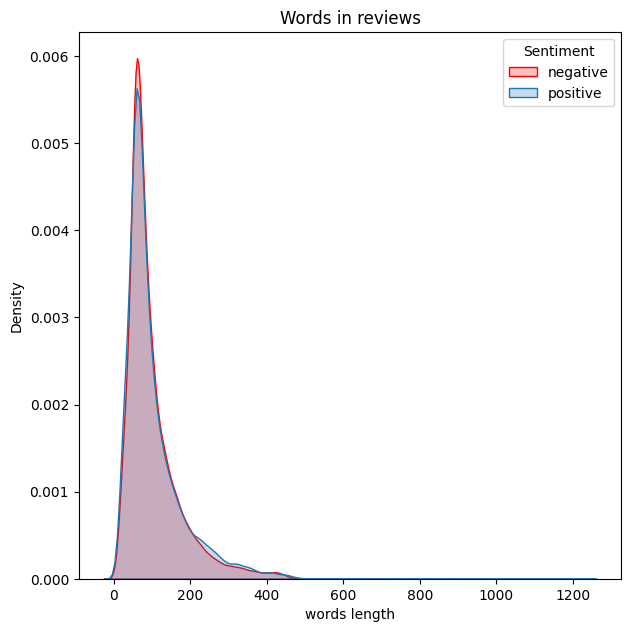

In [6]:
# positive words length
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title="Words in positive reviews")
plt.show(hist_positive)

# negative words length
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title="Words in negative reviews")
plt.show(hist_negative)

plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title="Words in reviews")
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show(kernel_distribution_number_words_plot)

## V. Train and test

In [7]:
label_encode = LabelEncoder()
x_data = df['review']
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42) 

### Vectorize data

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

#### Decision Tree Classifier

In [10]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.6879096500957951

#### Random Forest Classifier

In [11]:
rf_classifier = RandomForestClassifier(
    random_state=42
)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8209135827367148